# MSCS 634 - Lab 3  
**Name:** Sandesh Shrestha  
**Course:** MSCS-634
**Title**: Clustering Analysis Using K-Means and K-Medoids 


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [2]:
def k_medoids_pam(X, n_clusters=3, max_iter=300, random_state=42):
    """
    Minimal PAM (Partitioning Around Medoids) using Euclidean distance.
    Returns:
      labels: array of shape (n_samples,)
      medoid_indices: array of shape (n_clusters,)
    """
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    medoid_idx = rng.choice(n, size=n_clusters, replace=False)

    def pairwise_dist(A, B):
        # Euclidean distance between rows of A and rows of B
        AA = np.sum(A*A, axis=1)[:, None]
        BB = np.sum(B*B, axis=1)[None, :]
        d2 = AA + BB - 2 * (A @ B.T)
        d2 = np.maximum(d2, 0.0)
        return np.sqrt(d2)

    D = pairwise_dist(X, X[medoid_idx])
    labels = np.argmin(D, axis=1)

    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for m in range(n_clusters):
            non_medoids = [i for i in range(n) if i not in medoid_idx]
            for cand in non_medoids:
                trial = medoid_idx.copy()
                trial[m] = cand
                if len(np.unique(trial)) < n_clusters:
                    continue
                Dt = pairwise_dist(X, X[trial])
                lab_t = np.argmin(Dt, axis=1)
                cost_t = np.sum(Dt[np.arange(n), lab_t])
                cost = np.sum(D[np.arange(n), labels])
                if cost_t + 1e-9 < cost:
                    medoid_idx = trial
                    D = Dt
                    labels = lab_t
                    improved = True
    return labels, medoid_idx


## Step 1 — Load & Prepare the Dataset
- Load Wine dataset from `sklearn`
- Inspect shape, features, and class distribution
- Standardize features using z-score

In [4]:
# Load the dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

print("Shape:", X.shape)
print("Features:", feature_names)
vals, cnts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(vals, cnts)))
print("Class names:", target_names)

# Standardize with z-score
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2D PCA for visualization (metrics use X_std, not the PCA projection)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_std)

# Peek at a few rows
pd.DataFrame(X, columns=feature_names).assign(target=y).head()


Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Class distribution: {np.int64(0): np.int64(59), np.int64(1): np.int64(71), np.int64(2): np.int64(48)}
Class names: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Step 2 — K-Means (k = 3)
Obtain cluster labels, **Silhouette** and **ARI**.  
Centroids are shown as **X** markers.

K-Means -> Silhouette: 0.2849, ARI: 0.8975


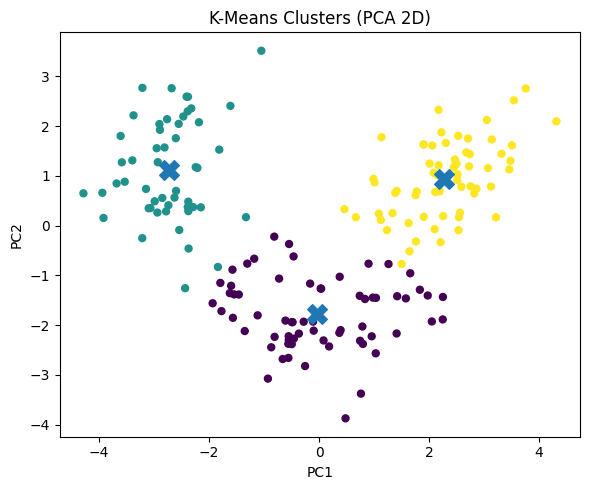

In [5]:
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_std)

kmeans_sil = silhouette_score(X_std, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print(f"K-Means -> Silhouette: {kmeans_sil:.4f}, ARI: {kmeans_ari:.4f}")

# Project centroids to the PCA space for display
centroids_2d = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, s=25)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='X', s=200)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Step 3 — K-Medoids (k = 3)
Obtain Cluster labels, **Silhouette**, and **ARI**.  
Medoids (actual data points) are shown as **◆** markers.

K-Medoids -> Silhouette: 0.2676, ARI: 0.7411


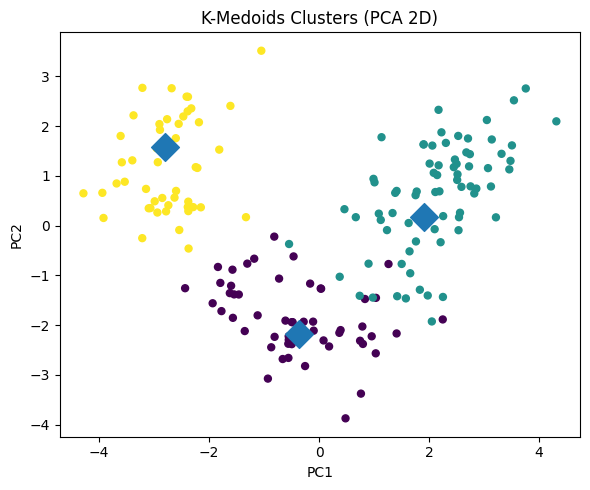

In [6]:
kmed_labels, kmed_medoids_idx = k_medoids_pam(X_std, n_clusters=3, max_iter=100, random_state=42)

kmed_sil = silhouette_score(X_std, kmed_labels)
kmed_ari = adjusted_rand_score(y, kmed_labels)

print(f"K-Medoids -> Silhouette: {kmed_sil:.4f}, ARI: {kmed_ari:.4f}")

# Medoids in PCA space (they’re rows from X_2d)
medoids_2d = X_2d[kmed_medoids_idx]

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmed_labels, s=25)
plt.scatter(medoids_2d[:, 0], medoids_2d[:, 1], marker='D', s=200)
plt.title("K-Medoids Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


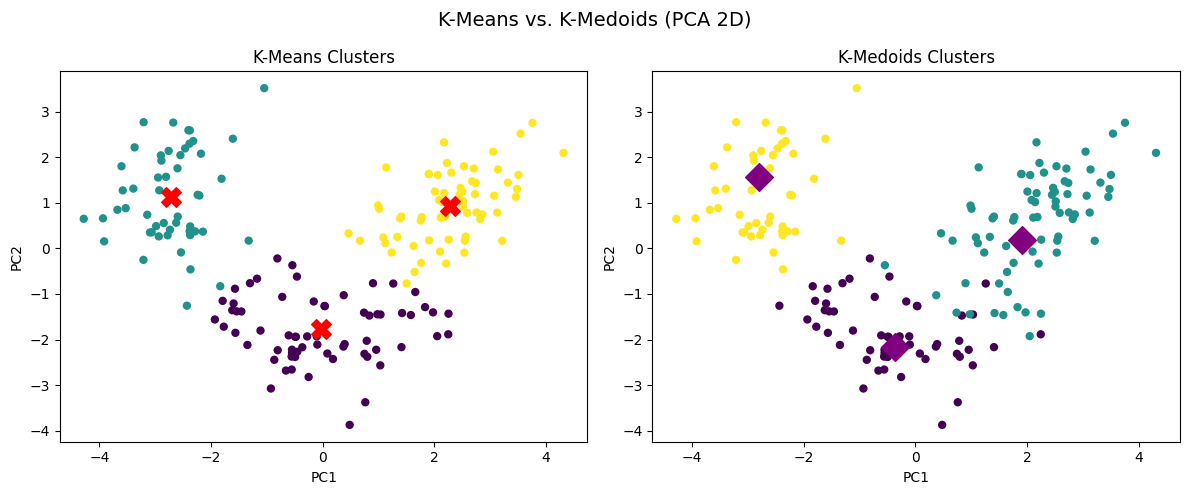

,Algorithm,Silhouette Score,Adjusted Rand Index
0,K-Means,0.284859,0.897495
1,K-Medoids,0.267622,0.741137


In [7]:
# Step 4: Visualize and Compare Results

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# K-Means
axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, s=25)
axes[0].scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='X', s=200, color='red')
axes[0].set_title("K-Means Clusters")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# K-Medoids
axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=kmed_labels, s=25)
axes[1].scatter(medoids_2d[:, 0], medoids_2d[:, 1], marker='D', s=200, color='purple')
axes[1].set_title("K-Medoids Clusters")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.suptitle("K-Means vs. K-Medoids (PCA 2D)", fontsize=14)
plt.tight_layout()
plt.show()

# Create a summary table
comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'K-Medoids'],
    'Silhouette Score': [kmeans_sil, kmed_sil],
    'Adjusted Rand Index': [kmeans_ari, kmed_ari]
})
display(comparison)

### Step 4 — Analysis and Comparison

**1) Which algorithm produced better-defined clusters?**  
Based on the evaluation metrics, **K-Means** produced better-defined clusters than K-Medoids.  
The Silhouette Score for K-Means (**0.2849**) was slightly higher than for K-Medoids (**0.2676**), indicating that K-Means formed more cohesive and well-separated clusters.  
Additionally, K-Means achieved a higher Adjusted Rand Index (**0.8975**) compared to K-Medoids (**0.7411**), showing stronger alignment with the actual wine class labels.

**2) What differences do you observe in cluster shapes or positioning?**  
From the PCA scatter plots, both algorithms identified similar overall structures, but with noticeable differences:
- **K-Means** formed **tighter, more compact, and roughly spherical clusters**, with centroids (X markers) located near the geometric centers of dense data regions.  
- **K-Medoids** produced **slightly irregularly shaped clusters**, as its medoids (◆ markers) are actual data samples. While this approach makes it more robust to potential outliers, the clusters appear somewhat less evenly distributed in this dataset.

**3) Based on your results, explain when K-Means or K-Medoids may be preferable.**  
- **K-Means** is preferable when working with well-scaled, continuous numerical data and when clusters are expected to be spherical or evenly distributed. It is also computationally faster for larger datasets.  
- **K-Medoids** is preferable when the dataset contains outliers, categorical data, or when interpretability is important, since medoids correspond to real data points.  

For the Wine dataset, **K-Means** performed better overall, producing more distinct clusters and a higher correspondence with the true class labels.
